# Clima

In [30]:
# Bibliotecas
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller

In [31]:
# Define o número de anos e cidades
num_anos = 100
cidades = ['Recife', 'Olinda', 'Paulista', 'Jaboatão']
num_cidades = len(cidades)
registros_por_cidade = 365.25 * num_anos

# Cria um DataFrame vazio
df = pd.DataFrame()

# Gera o ID sequencial
df['ID'] = range(1, int(registros_por_cidade * num_cidades) + 1)

# Gera as datas para os últimos 100 anos
dates = pd.date_range(end='2023-12-31', periods=int(registros_por_cidade))
date_list = []
for _ in range(num_cidades):
  date_list.extend(dates)
df['Data'] = date_list

# Gera as cidades aleatoriamente para cada registro
df['Cidade'] = np.tile(cidades, int(registros_por_cidade))


# Gera a temperatura média com tendência de crescimento e outliers
def gerar_temperatura(ano):
    base_temp = 25 + (ano/100) * 1.5
    temperatura = base_temp + np.random.normal(0, 2)
    if random.random() < 0.05:  # 5% de chance de outlier
      temperatura = temperatura + random.uniform(5, 10)
    return temperatura

# Aplica função para cada linha do DataFrame
df['Temperatura_Média'] = df.apply(lambda row: gerar_temperatura(row.name % 36525 // 365.25), axis=1)

# Gera outros dados climáticos com valores nulos aleatórios
df['Velocidade_Vento'] = np.random.uniform(0, 10, size=len(df))
df.loc[np.random.choice(df.index, size=int(0.1 * len(df)), replace=False), 'Velocidade_Vento'] = np.nan

df['Umidade_Relativa'] = np.random.uniform(30, 95, size=len(df))
df.loc[np.random.choice(df.index, size=int(0.1 * len(df)), replace=False), 'Umidade_Relativa'] = np.nan

df['Precipitação'] = np.random.uniform(0, 15, size=len(df))
df.loc[np.random.choice(df.index, size=int(0.05 * len(df)), replace=False), 'Precipitação'] = np.nan

df['CO2'] = np.random.uniform(380, 420, size=len(df))
df.loc[np.random.choice(df.index, size=int(0.1 * len(df)), replace=False), 'CO2'] = np.nan

# Salva o DataFrame em um arquivo CSV com ponto e vírgula como delimitador
df.to_csv('clima.csv', sep=';', index=False)

print("Dataset criado com sucesso!")

Dataset criado com sucesso!


In [32]:
# Carrega o arquivo CSV em um DataFrame, especificando o separador como ponto e vírgula
dataset = pd.read_csv('clima.csv', sep=';')

# Exibe as 10 primeiras linhas do DataFrame como uma string
print(dataset.head(10).to_string())

   ID        Data    Cidade  Temperatura_Média  Velocidade_Vento  Umidade_Relativa  Precipitação         CO2
0   1  1924-01-01    Recife          27.577267          0.823760         77.785857     11.920762  404.415320
1   2  1924-01-02    Olinda          22.589886          1.819101         56.794996      3.573231         NaN
2   3  1924-01-03  Paulista          25.300238          3.438230         33.099604      6.207840  389.015729
3   4  1924-01-04  Jaboatão          27.941695          5.158445         41.191254     13.584951  405.780112
4   5  1924-01-05    Recife          25.279778          6.849448         50.698995      0.652852  413.696522
5   6  1924-01-06    Olinda          24.000252          5.987585         87.741560     14.901987  402.386455
6   7  1924-01-07  Paulista          27.686763          5.827338         39.680436      2.624800  410.273738
7   8  1924-01-08  Jaboatão          24.622013               NaN         56.903559      1.050842  388.238917
8   9  1924-01-09  

In [33]:
# Exibe informações sobre o dataset no formato string
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146100 entries, 0 to 146099
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 146100 non-null  int64  
 1   Data               146100 non-null  object 
 2   Cidade             146100 non-null  object 
 3   Temperatura_Média  146100 non-null  float64
 4   Velocidade_Vento   131490 non-null  float64
 5   Umidade_Relativa   131490 non-null  float64
 6   Precipitação       138795 non-null  float64
 7   CO2                131490 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 8.9+ MB
None


In [34]:
# Exibe as dimensões do dataset
dataset.shape

(146100, 8)

In [35]:
# quantidade de nulos
print(dataset.isnull().sum())

ID                       0
Data                     0
Cidade                   0
Temperatura_Média        0
Velocidade_Vento     14610
Umidade_Relativa     14610
Precipitação          7305
CO2                  14610
dtype: int64


**Análise Estatística do Contexto**

Distribuição dos Dados: Analisar a distribuição da variável com dados ausentes pode indicar se a média, mediana ou moda é mais apropriada. Onde, Dados simétricos, a média geralmente é mais indicada; Dados assimétricos, a mediana tende a ser melhor; e, Variáveis categóricas, a moda é o padrão mais comum.

In [36]:
# Função para aplicar o modelo baseado em correlação
def aplicar_modelo_correlacao(df):
    df_preenchido = df.copy()  # Cria uma cópia para não modificar o DataFrame original
    for coluna in df.columns:
        if df[coluna].isnull().any():
            if pd.api.types.is_numeric_dtype(df[coluna]):
                if df[coluna].skew() > 0.5 or df[coluna].skew() < -0.5: # Verifica assimetria
                    # Aplica a mediana para dados assimétricos
                    df_preenchido[coluna] = df[coluna].fillna(df[coluna].median())
                    print(f"Coluna '{coluna}': Aplicando Mediana")
                else:
                    # Aplica a média para dados simétricos
                    df_preenchido[coluna] = df[coluna].fillna(df[coluna].mean())
                    print(f"Coluna '{coluna}': Aplicando Média")
            else:
                # Aplica a moda para colunas categóricas
                df_preenchido[coluna] = df[coluna].fillna(df[coluna].mode()[0])
                print(f"Coluna '{coluna}': Aplicando Moda")
    return df_preenchido

# Aplica o modelo baseado em correlação no dataset
dataset = aplicar_modelo_correlacao(dataset)

Coluna 'Velocidade_Vento': Aplicando Média
Coluna 'Umidade_Relativa': Aplicando Média
Coluna 'Precipitação': Aplicando Média
Coluna 'CO2': Aplicando Média


In [37]:
# quantidade de nulos
print(dataset.isnull().sum())

ID                   0
Data                 0
Cidade               0
Temperatura_Média    0
Velocidade_Vento     0
Umidade_Relativa     0
Precipitação         0
CO2                  0
dtype: int64


## Identificação e Extração de Outliers

In [38]:
# técnica Interquartil Range (IQR)
def iqr_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

# Aplicar IQR para 'Temperatura_Média'
outliers_temp = iqr_outliers(dataset, 'Temperatura_Média')

# Calcular a contaminação por outliers
num_outliers_temp = len(outliers_temp)
total_temp = len(dataset)
contaminacao_temp = num_outliers_temp / total_temp


print(f"Número de outliers em Temperatura_Média: {num_outliers_temp}")
print(f"Total de registros em Temperatura_Média: {total_temp}")
print(f"Contaminação por outliers em Temperatura_Média (percentual): {contaminacao_temp * 100:.2f}%")


#Criando a coluna is_outlier
dataset['is_outlier'] = 0  # Inicializa a coluna com 0 para todos os registros
dataset.loc[dataset.index.isin(outliers_temp.index), 'is_outlier'] = 1 # Marca com 1 os outliers

# Exibir as primeiras linhas do DataFrame atualizado
print(dataset.head().to_string())

Número de outliers em Temperatura_Média: 5743
Total de registros em Temperatura_Média: 146100
Contaminação por outliers em Temperatura_Média (percentual): 3.93%
   ID        Data    Cidade  Temperatura_Média  Velocidade_Vento  Umidade_Relativa  Precipitação         CO2  is_outlier
0   1  1924-01-01    Recife          27.577267          0.823760         77.785857     11.920762  404.415320           0
1   2  1924-01-02    Olinda          22.589886          1.819101         56.794996      3.573231  400.030264           0
2   3  1924-01-03  Paulista          25.300238          3.438230         33.099604      6.207840  389.015729           0
3   4  1924-01-04  Jaboatão          27.941695          5.158445         41.191254     13.584951  405.780112           0
4   5  1924-01-05    Recife          25.279778          6.849448         50.698995      0.652852  413.696522           0


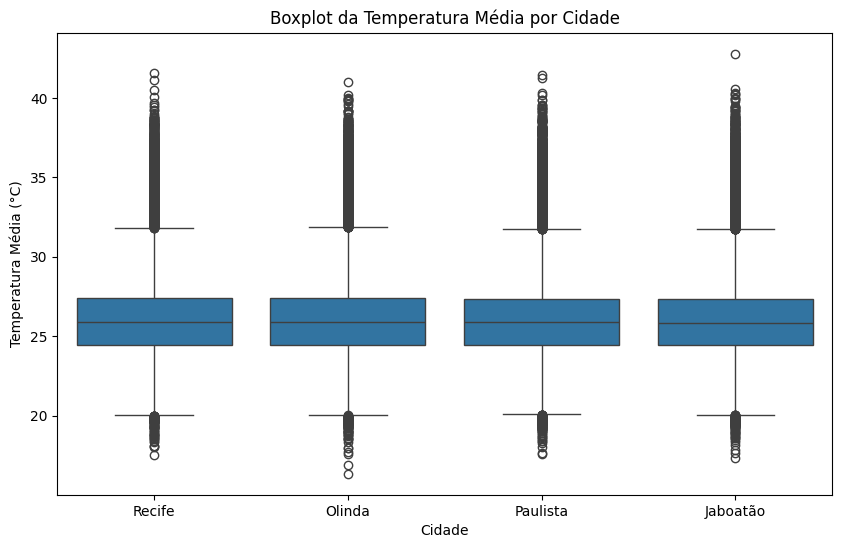

In [39]:
# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cidade', y='Temperatura_Média', data=dataset)
plt.title('Boxplot da Temperatura Média por Cidade')
plt.xlabel('Cidade')
plt.ylabel('Temperatura Média (°C)')
plt.show()

In [40]:
# Quantidade de outliers identificados
print(f"Quantidade de outliers: {dataset['is_outlier'].sum()}")

Quantidade de outliers: 5743


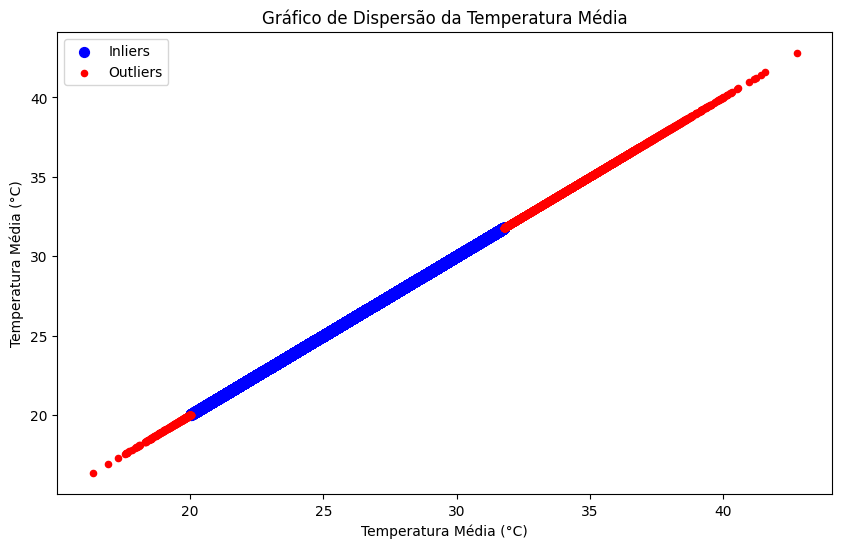

In [41]:
# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))

# Plotar os pontos que não são outliers (inliers) em azul e com tamanho maior
plt.scatter(dataset[dataset['is_outlier'] == 0]['Temperatura_Média'],
            dataset[dataset['is_outlier'] == 0]['Temperatura_Média'],
            color='blue', label='Inliers', s=50) # s define o tamanho do marcador

# Plotar os pontos que são outliers em vermelho e com tamanho menor
plt.scatter(dataset[dataset['is_outlier'] == 1]['Temperatura_Média'],
            dataset[dataset['is_outlier'] == 1]['Temperatura_Média'],
            color='red', label='Outliers', s=20) # s define o tamanho do marcador

plt.xlabel('Temperatura Média (°C)')
plt.ylabel('Temperatura Média (°C)')
plt.title('Gráfico de Dispersão da Temperatura Média')
plt.legend()
plt.show()

In [42]:
# Remove registros com 'is_outlier' igual a 1
dataset = dataset[dataset['is_outlier'] != 1]

# exibir a forma do dataset
print(dataset.shape)

(140357, 9)


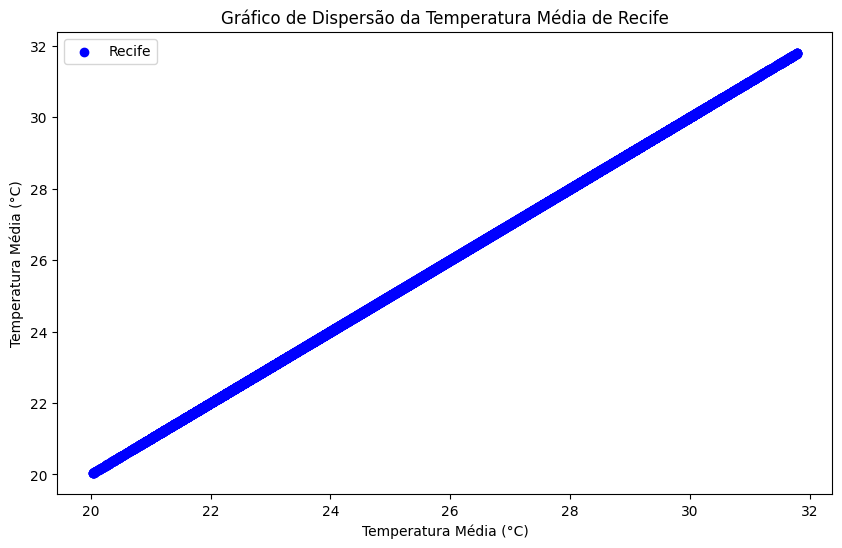

In [43]:
# Criar o gráfico de dispersão apenas para Recife
recife_data = dataset[dataset['Cidade'] == 'Recife']

plt.figure(figsize=(10, 6))

# Plotar os pontos
plt.scatter(recife_data['Temperatura_Média'], recife_data['Temperatura_Média'], color='blue', label='Recife')

plt.xlabel('Temperatura Média (°C)')
plt.ylabel('Temperatura Média (°C)')
plt.title('Gráfico de Dispersão da Temperatura Média de Recife')
plt.legend()
plt.show()

In [44]:
#forma do dataset
dataset.shape

(140357, 9)

In [45]:
# Convert the 'Data' column to datetime objects, coercing errors to NaT
dataset['Data'] = pd.to_datetime(dataset['Data'], errors='coerce')

# Drop rows where the 'Data' column is NaT (invalid dates)
dataset = dataset.dropna(subset=['Data'])

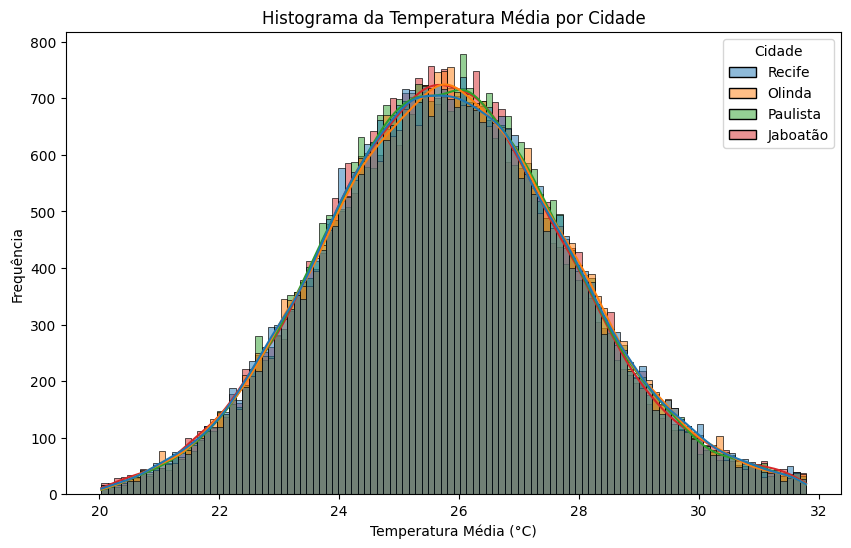

In [46]:
# Histograma das temperaturas médias por cidade
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, x='Temperatura_Média', hue='Cidade', kde=True)
plt.title('Histograma da Temperatura Média por Cidade')
plt.xlabel('Temperatura Média (°C)')
plt.ylabel('Frequência')
plt.show()

## AutoRegressive Integrated Moving Average (ARIMA)

**AutoRegressive Integrated Moving Average (ARIMA)**

Para previsão de séries temporais.

Combina três componentes:

1. AR (AutoRegressive): Depende de valores passados - Usa a relação linear entre o valor atual e seus valores passados (lags). Por exemplo, um AR(1) usa o valor imediatamente anterior para prever o atual.

2. I (Integrated): Diferença os dados para torná-los estacionários - Representa a diferenciação dos dados para torná-los estacionários, ou seja, remover tendências ou sazonalidades. Um d=1 significa que aplicamos a diferença entre Xt - Xt-1.

3. MA (Moving Average): Modela o erro com base em erros anteriores - Modela a relação entre o valor atual e os erros passados da previsão. Um MA(1) usa o erro do último período para ajustar o modelo.

ARIMA(p, d, q) onde:

1. p: Ordem de autoregressão (quantos valores passados são usados).

2. d: Número de diferenciações.

3. q: Ordem da média móvel (quantos erros passados são considerados).

Etapas:

1. Análise de dados - Verifica se a série é estacionária.
Se não for, aplica-se a diferenciação (d).

2. Verificação de estacionariedade - Gráficos ACF (autocorrelação) e PACF (autocorrelação parcial) ajudam a determinar p e q.

3. Ajuste de parâmetros - Analisa os resíduos e avalia a precisão do modelo com métricas como AIC e BIC, e, com o modelo ajustado, projeta valores futuros.

4. Validação e previsão.

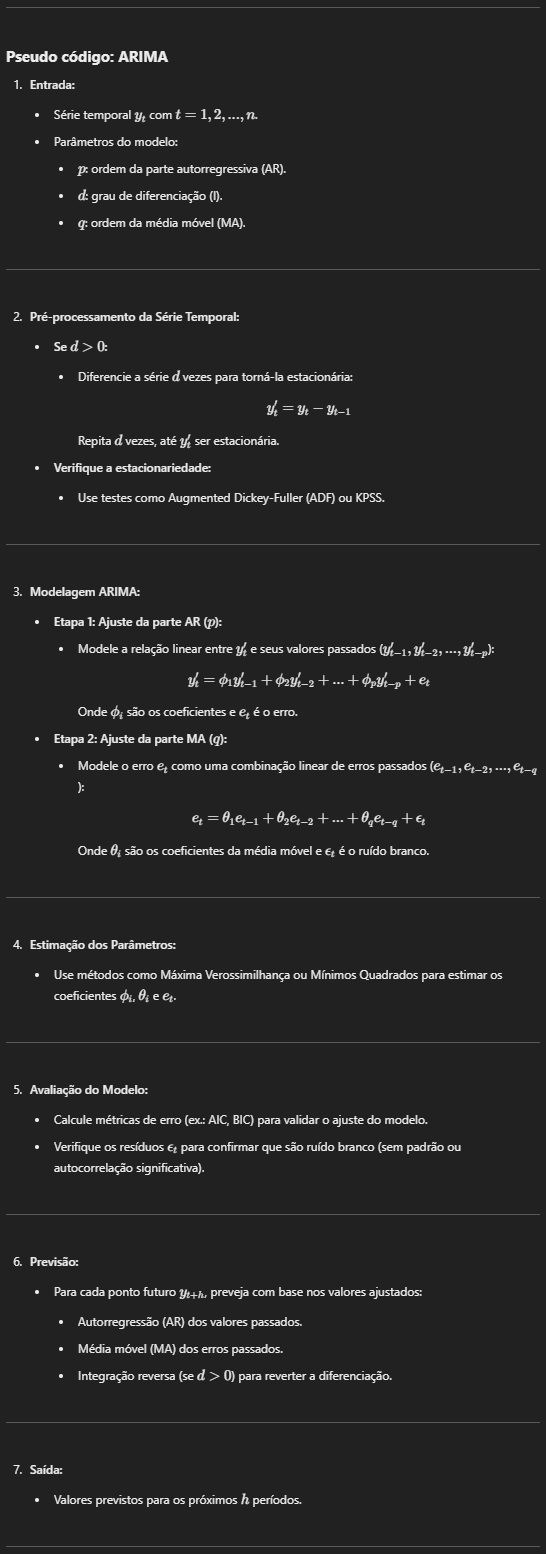

<ipython-input-47-b64c56f63307>:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  recife_data_anual = recife_data['Temperatura_Média'].resample('Y').mean()


ADF Statistic: -0.286109
p-value: 0.927449
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


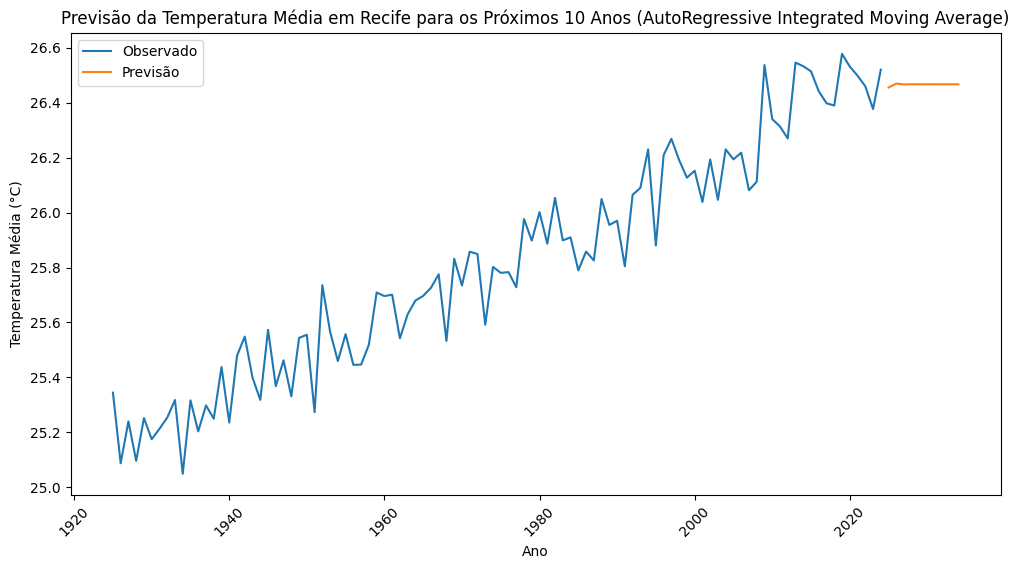

In [47]:
# Filtrar dados para Recife
recife_data = dataset[dataset['Cidade'] == 'Recife'].copy()

# Converter a coluna 'Data' para o formato datetime e definir como índice
recife_data['Data'] = pd.to_datetime(recife_data['Data'], format='%Y-%m-%d', errors='coerce')
recife_data = recife_data.dropna(subset=['Data'])
recife_data['Data'] = recife_data['Data'].dt.strftime('%d-%m-%Y')
recife_data = recife_data.set_index('Data')


# Converter o índice para datetime
recife_data.index = pd.to_datetime(recife_data.index, format='%d-%m-%Y')

# Re-amostra os dados para frequência anual, calculando a média da temperatura
recife_data_anual = recife_data['Temperatura_Média'].resample('Y').mean()

# Testa a estacionariedade da série temporal
result = adfuller(recife_data_anual)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Se a série não for estacionária, aplica a diferenciação
if result[1] > 0.05:
    recife_data_anual_diff = recife_data_anual.diff().dropna()
else:
    recife_data_anual_diff = recife_data_anual

# Define os parâmetros do modelo ARIMA (p, d, q)
p = 1  # Ordem de autoregressão
d = 1  # Número de diferenciações
q = 1  # Ordem da média móvel
modelo = ARIMA(recife_data_anual, order=(p, d, q))

# Ajusta o modelo aos dados
modelo_ajustado = modelo.fit()

# Previsões para os próximos 10 anos
previsoes = modelo_ajustado.predict(start=len(recife_data_anual), end=len(recife_data_anual) + 9)

# Plota os dados observados e as previsões
plt.figure(figsize=(12, 6))
plt.plot(recife_data_anual, label='Observado')
plt.plot(previsoes, label='Previsão')

# Formata o eixo x para mostrar os anos
plt.xticks(rotation=45)
plt.xlabel('Ano')
plt.ylabel('Temperatura Média (°C)')
plt.title('Previsão da Temperatura Média em Recife para os Próximos 10 Anos (AutoRegressive Integrated Moving Average)')
plt.legend()
plt.show()

## Random Forest Regressor (RFR)

**Random Forest Regressor**

 Random Forest Regressor é uma extensão do método Random Forest (originalmente projetado para classificação), mas adaptado para prever valores contínuos. Ele utiliza o conceito de "bagging" (Bootstrap Aggregating) para criar um conjunto de árvores de decisão que, juntas, produzem resultados mais robustos e precisos.

 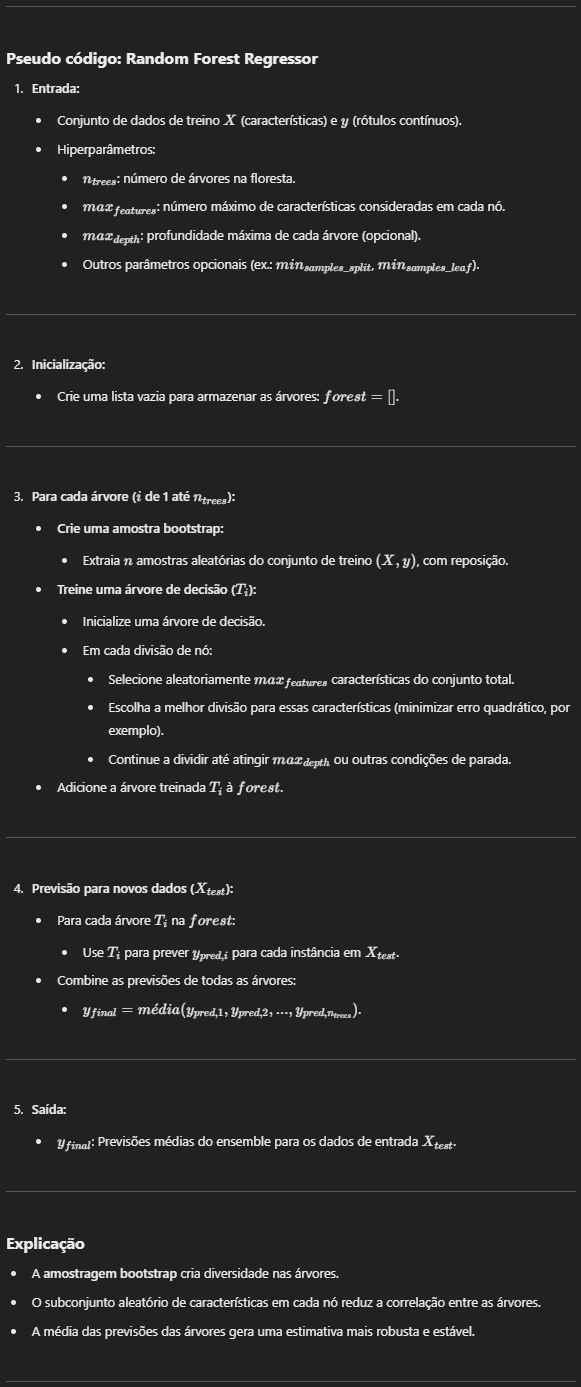

Mean Squared Error: 4.236392441513248


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


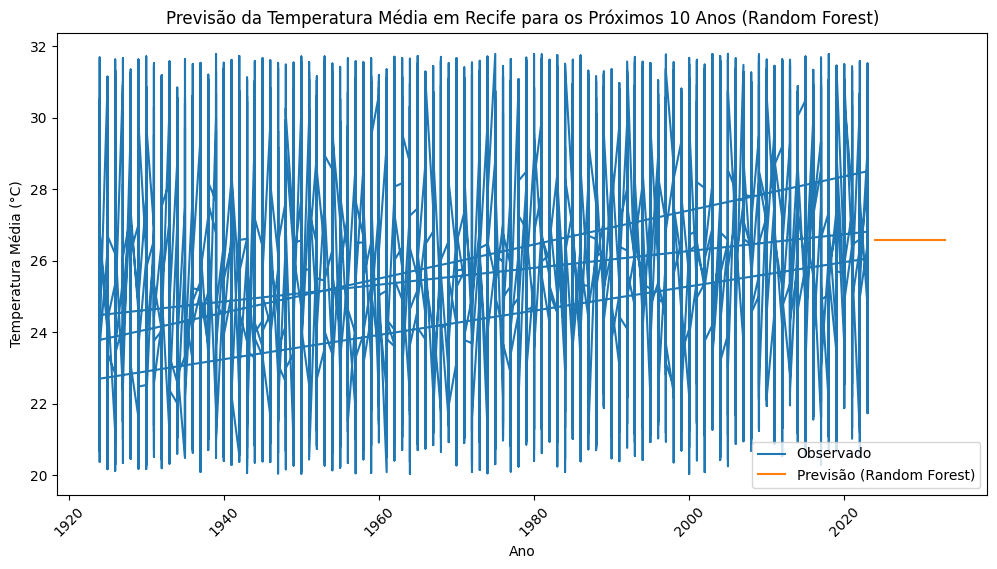

In [48]:
# Preparação dos dados para o Random Forest
recife_data['Ano'] = recife_data.index.year
X = recife_data[['Ano']]
y = recife_data['Temperatura_Média']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42) # Ajuste n_estimators conforme necessário
modelo_rf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = modelo_rf.predict(X_test)

# Avaliar o modelo (opcional)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Previsões para os próximos 10 anos
anos_futuros = np.arange(recife_data['Ano'].max() + 1, recife_data['Ano'].max() + 11).reshape(-1, 1)
previsoes_rf = modelo_rf.predict(anos_futuros)

# Plota os dados observados e as previsões
plt.figure(figsize=(12, 6))
plt.plot(recife_data['Ano'], recife_data['Temperatura_Média'], label='Observado')
plt.plot(anos_futuros, previsoes_rf, label='Previsão (Random Forest)')

# Formata o eixo x para mostrar os anos
plt.xticks(rotation=45)
plt.xlabel('Ano')
plt.ylabel('Temperatura Média (°C)')
plt.title('Previsão da Temperatura Média em Recife para os Próximos 10 Anos (Random Forest)')
plt.legend()
plt.show()

## Prophet

**PROPHET (PROFETA)**

Modelo desenvolvido pelo time de pesquisa do Facebook (agora Meta) para análise e previsão de séries temporais. Ele foi projetado para lidar com séries que apresentam padrões sazonais, feriados, mudanças de tendência e outros componentes estruturais, tornando-o uma escolha poderosa e fácil de usar, especialmente para séries com características complexas.

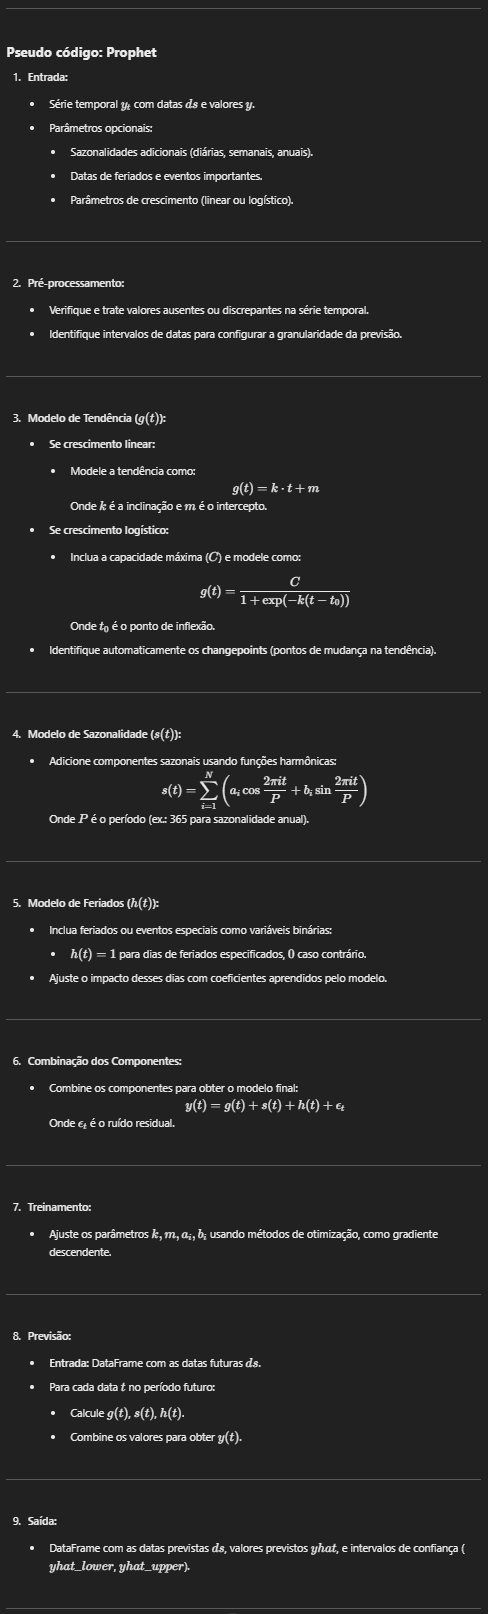

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmple5q5fln/gxr9osu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmple5q5fln/lr2zwgj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50510', 'data', 'file=/tmp/tmple5q5fln/gxr9osu9.json', 'init=/tmp/tmple5q5fln/lr2zwgj7.json', 'output', 'file=/tmp/tmple5q5fln/prophet_model94fo1127/prophet_model-20241206164807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


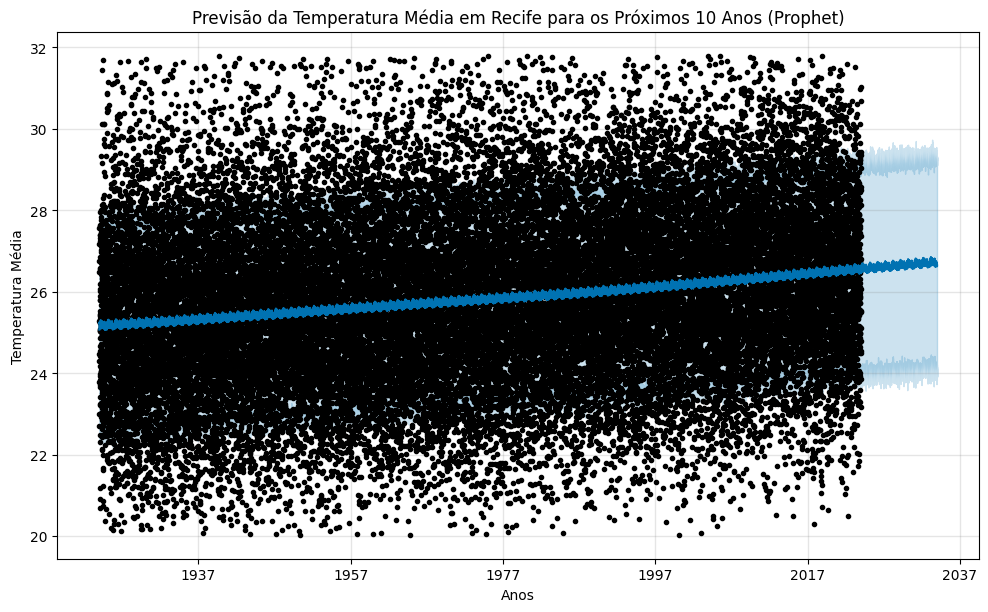

In [49]:
# Preparação dos dados para o Prophet
recife_data = dataset[dataset['Cidade'] == 'Recife'].copy()
recife_data['Data'] = pd.to_datetime(recife_data['Data'], errors='coerce')
recife_data = recife_data.dropna(subset=['Data'])
recife_data['Data'] = recife_data['Data'].dt.strftime('%d-%m-%Y')

# Criar um DataFrame para o Prophet
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(recife_data['Data'], format='%d-%m-%Y')
df_prophet['y'] = recife_data['Temperatura_Média']

# Inicializar e ajustar o modelo Prophet
model = Prophet()
model.fit(df_prophet)

# Criar um DataFrame para as previsões futuras (10 anos)
future = model.make_future_dataframe(periods=365 * 10)

# Fazer as previsões
forecast = model.predict(future)

# Plotar os resultados
fig = model.plot(forecast)
plt.xlabel('Anos')
plt.ylabel('Temperatura Média')
plt.title('Previsão da Temperatura Média em Recife para os Próximos 10 Anos (Prophet)')
plt.show()

## Linear Regression (LIR)

**Regressão Linear**

Método estatístico usado para modelar a relação entre uma ou mais variáveis independentes (também chamadas de preditoras ou explicativas) e uma variável dependente (ou alvo), assumindo que a relação entre elas é linear.

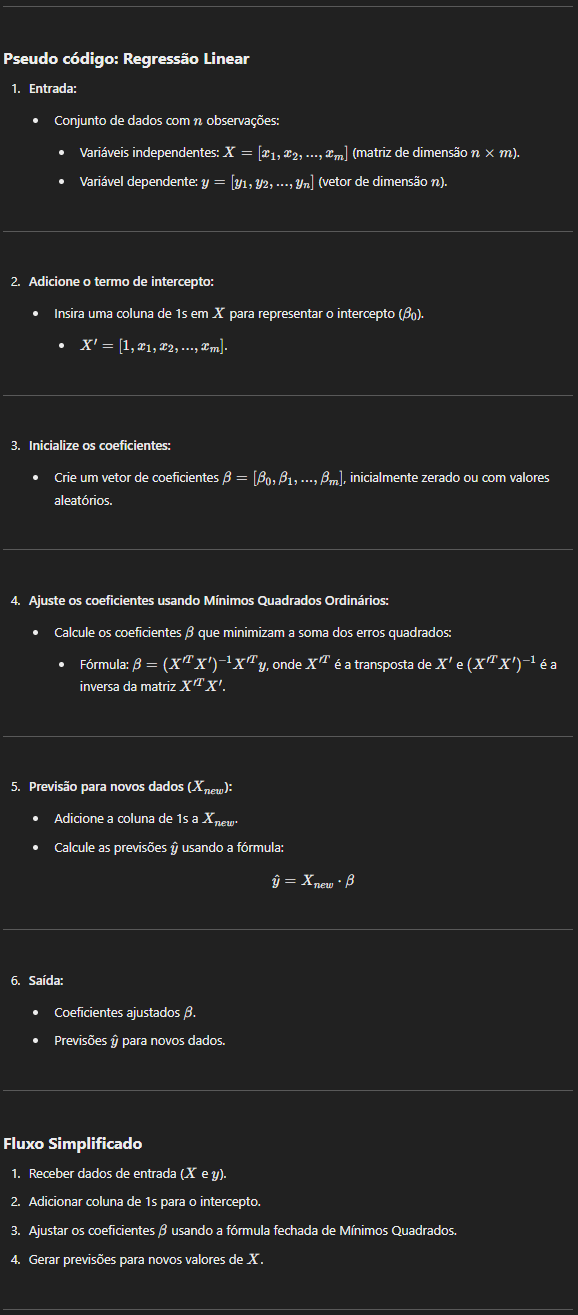

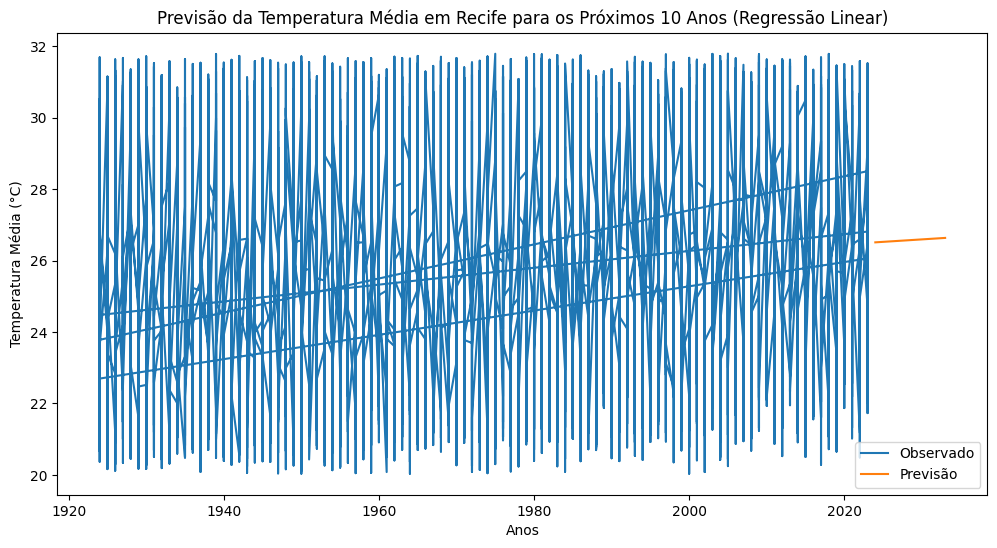

In [50]:
# Convertendo a coluna 'Data' para o formato desejado e removendo datas inválidas
dataset['Data'] = pd.to_datetime(dataset['Data'], errors='coerce')
dataset = dataset.dropna(subset=['Data'])
dataset['Data'] = dataset['Data'].dt.strftime('%d-%m-%Y')

# Filtrando os dados para a cidade de Recife
recife_data = dataset[dataset['Cidade'] == 'Recife'].copy()

# Convertendo a coluna 'Data' para datetime e definindo como índice
recife_data['Data'] = pd.to_datetime(recife_data['Data'], format='%d-%m-%Y')
recife_data = recife_data.set_index('Data')

# Criando a coluna 'Ano' a partir do índice de data
recife_data['Ano'] = recife_data.index.year

# Preparando os dados para a regressão linear
X = recife_data[['Ano']]
y = recife_data['Temperatura_Média']

# Criando e treinando o modelo de regressão linear
model = LinearRegression()
model.fit(X, y)

# Criando os dados para prever os próximos 10 anos
future_years = pd.DataFrame({'Ano': range(recife_data['Ano'].max() + 1, recife_data['Ano'].max() + 11)})

# Fazendo as previsões
predictions = model.predict(future_years)

# Plotando os resultados
plt.figure(figsize=(12, 6))
plt.plot(recife_data['Ano'], recife_data['Temperatura_Média'], label='Observado')
plt.plot(future_years['Ano'], predictions, label='Previsão')
plt.xlabel('Anos')
plt.ylabel('Temperatura Média (°C)')
plt.title('Previsão da Temperatura Média em Recife para os Próximos 10 Anos (Regressão Linear)')
plt.legend()
plt.show()

## K-Nearest Neighbors (KNN)

**K Vizinhos Mais Próximo**

Algoritmo simples e intuitivo que pode ser adaptado para análise e previsão de séries temporais, embora não seja tradicionalmente usado para isso. Ele funciona buscando os K pontos mais próximos no passado que são semelhantes a um padrão atual e utilizando essas informações para fazer previsões futuras.

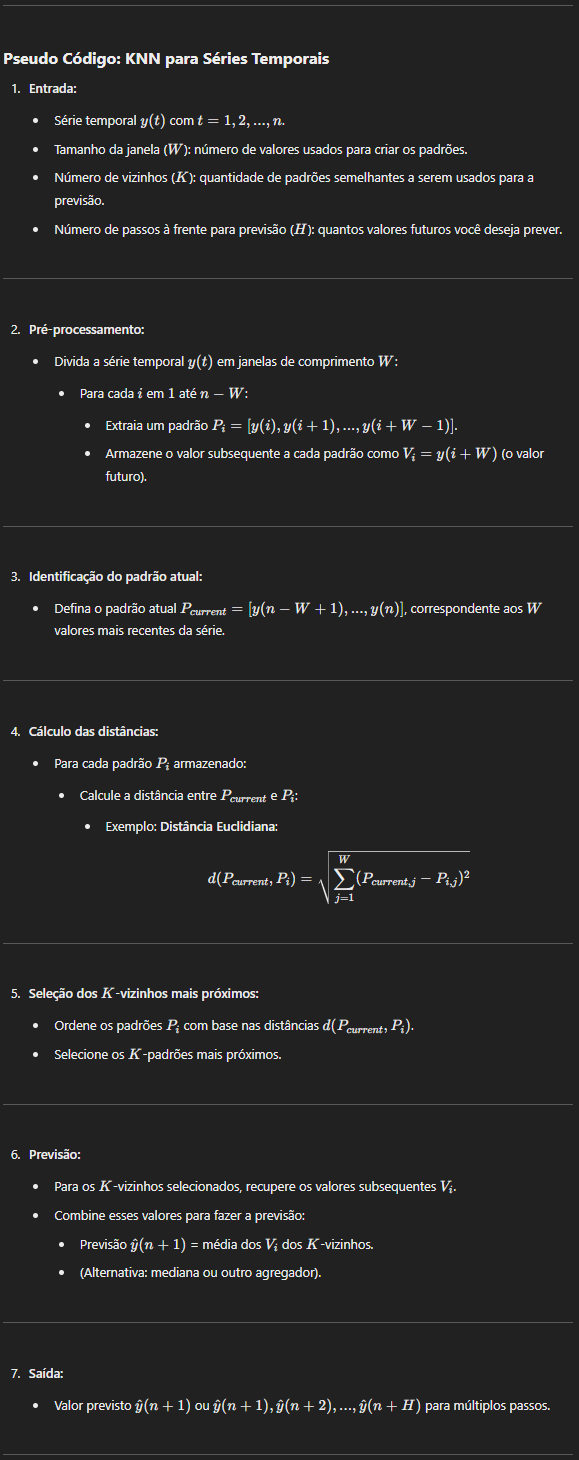

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


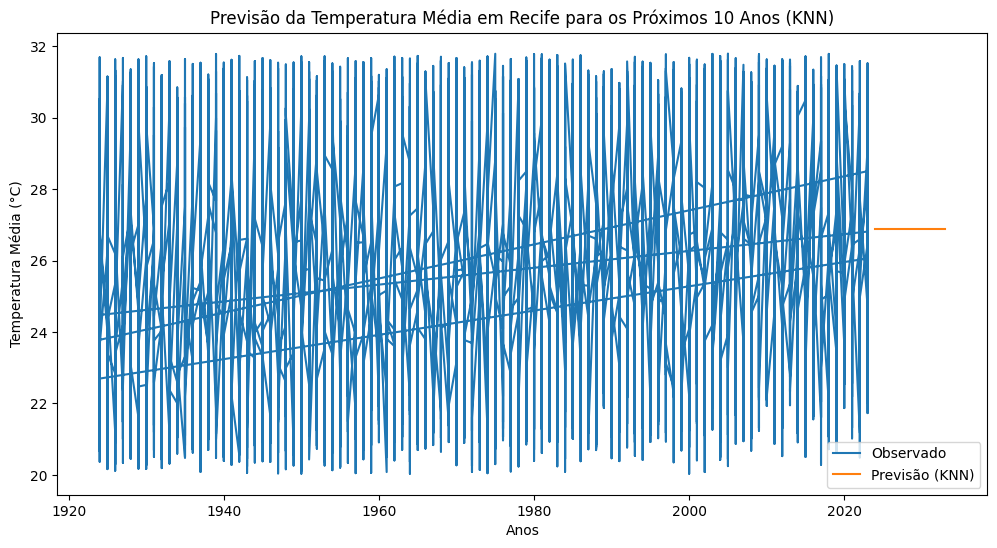

In [51]:
# Preparação dos dados para o KNN
recife_data = dataset[dataset['Cidade'] == 'Recife'].copy()

# Convertendo a coluna 'Data' para datetime e definindo como índice
recife_data['Data'] = pd.to_datetime(recife_data['Data'], format='%d-%m-%Y')
recife_data = recife_data.set_index('Data')

# Criando a coluna 'Ano' a partir do índice de data
recife_data['Ano'] = recife_data.index.year

# Criando a variável independente (X) e dependente (y)
X = recife_data[['Ano']]  # Considerando apenas o ano como variável independente
y = recife_data['Temperatura_Média']

# Criando e treinando o modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Define o número de vizinhos
knn_model.fit(X, y)


# Previsões para os próximos 10 anos
future_years = np.arange(recife_data['Ano'].max() + 1, recife_data['Ano'].max() + 11).reshape(-1, 1)
predictions = knn_model.predict(future_years)

# Plotando os resultados
plt.figure(figsize=(12, 6))
plt.plot(recife_data['Ano'], recife_data['Temperatura_Média'], label='Observado')
plt.plot(future_years, predictions, label='Previsão (KNN)')
plt.xlabel('Anos')
plt.ylabel('Temperatura Média (°C)')
plt.title('Previsão da Temperatura Média em Recife para os Próximos 10 Anos (KNN)')
plt.legend()
plt.show()

## Support Vector Machine (SVM)

**Máquina de Vetor de Suporte para Séries Temporais**

Originalmente foi desenvolvido para tarefas de classificação e regressão. Quando adaptado para séries temporais, ele atua como um modelo de regressão (SVR, ou Support Vector Regression), prevendo valores futuros com base em padrões encontrados nos dados históricos.

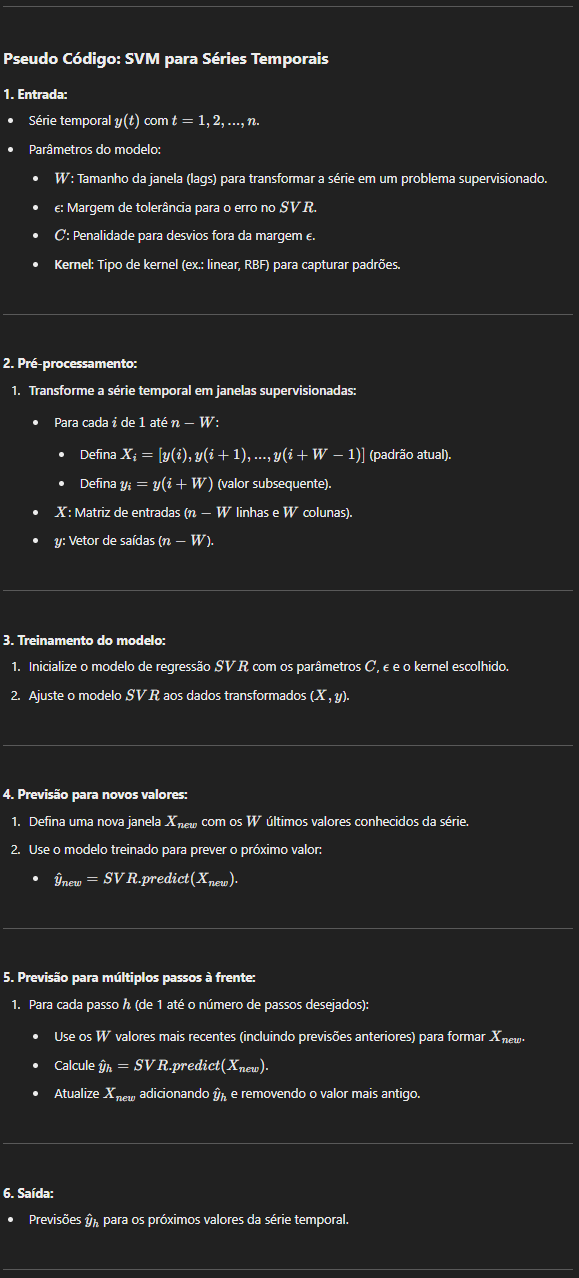

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


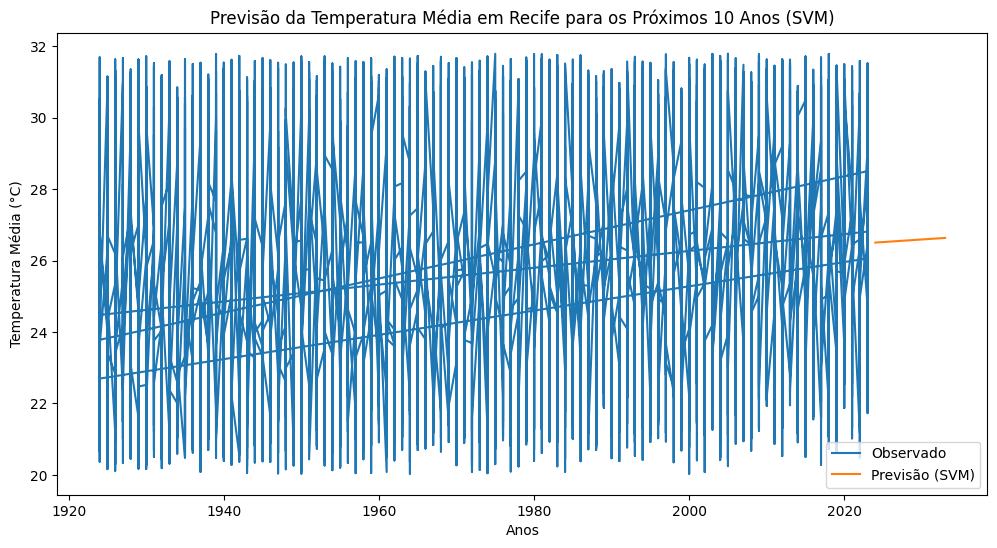

In [52]:
# Preparação dos dados para o SVM
recife_data = dataset[dataset['Cidade'] == 'Recife'].copy()

# Convertendo a coluna 'Data' para datetime e definindo como índice
recife_data['Data'] = pd.to_datetime(recife_data['Data'], format='%d-%m-%Y')
recife_data = recife_data.set_index('Data')

# Criando a coluna 'Ano' a partir do índice de data
recife_data['Ano'] = recife_data.index.year

# Criando a variável independente (X) e dependente (y)
X = recife_data[['Ano']]
y = recife_data['Temperatura_Média']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo SVM
svm_model = SVR(kernel='linear') # Escolha um kernel apropriado (linear, rbf, poly, etc.)
svm_model.fit(X_train, y_train)

# Previsões para os próximos 10 anos
future_years = np.arange(recife_data['Ano'].max() + 1, recife_data['Ano'].max() + 11).reshape(-1, 1)
predictions = svm_model.predict(future_years)

# Plotando os resultados
plt.figure(figsize=(12, 6))
plt.plot(recife_data['Ano'], recife_data['Temperatura_Média'], label='Observado')
plt.plot(future_years, predictions, label='Previsão (SVM)')
plt.xlabel('Anos')
plt.ylabel('Temperatura Média (°C)')
plt.title('Previsão da Temperatura Média em Recife para os Próximos 10 Anos (SVM)')
plt.legend()
plt.show()